## MMAI 5500 Assignment 2

Jiawen Li

In [1]:
pip install -q datasets transformers evaluate timm albumentations

In [2]:
from huggingface_hub import notebook_login

notebook_login()

#### Read the COCO formatted annotations to a dict

In [3]:
import json
with open('/content/MMAI_5500_A2/result.json') as f:
  cocodata = json.load(f)

#### Convert the COCO formatted dict to a format readable by dataset.load_dataset().

In [4]:
# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
  # Remove the image directory from the file name
  image['file_name'] = image['file_name'].split('/')[-1]
  image['image_id'] = image['id']
  # Extend the image dict with bounding boxes and class labels
  image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
  # Iterate through the annotations (bounding boxes and labels)
  for annot in cocodata['annotations']:
    # Check if the annotation matches the image
    if annot['image_id'] == image['id']:
      # Add the annotation
      image['objects']['bbox'].append(annot['bbox'])
      image['objects']['category'].append(annot['category_id'])
      image['objects']['area'].append(annot['area'])
      image['objects']['id'].append(annot['id'])
  # Append the image dict with annotations to the list
  huggingdata.append(image)

#### Write the Huggingface formatted annotations to a json file.

In [5]:
with open("metadata.jsonl", 'w') as f:
  for item in huggingdata:
    f.write(json.dumps(item) + "\n")

#### Organize the images and metadata.jsonl into the correct folder structure

In [6]:
from datasets import load_dataset

#### Read the data into a DatasetDict.

In [7]:
from datasets import load_dataset
candy_data = load_dataset('imagefolder', data_dir="/content/MMAI_5500_A2")

#### Split the candy_data['train'], store the first 10 images as trainning data, and the last one with ID=10 to be the test data for evaluation later.

In [8]:
test_data = 10
def split_dataset_specific_test(dataset, test_data):

    test = dataset.filter(lambda sample: sample['id'] == test_data)

    train = dataset.filter(lambda sample: sample['id'] != test_data)
    return train, test

# Use the split_dataset_specific_test function
train, test = split_dataset_specific_test(candy_data['train'], test_data)

In [9]:
train, test

(Dataset({
     features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
     num_rows: 10
 }),
 Dataset({
     features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
     num_rows: 1
 }))

### Preprocess the data

In [10]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


To make sure the model does not overfit on the training data, we can apply image augmentation using Albumentations

In [11]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [12]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

Combine the image and annotation transformations to use on a batch of examples:

In [13]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [14]:
candy_data["train"] = candy_data["train"].with_transform(transform_aug_ann)
candy_data["train"][10]

{'pixel_values': tensor([[[-1.3987, -1.3987, -1.4158,  ..., -1.0390, -1.0562, -1.0733],
          [-1.3987, -1.3987, -1.3987,  ..., -1.0390, -1.0562, -1.0733],
          [-1.3815, -1.3815, -1.3644,  ..., -1.0390, -1.0562, -1.0562],
          ...,
          [-1.0219, -1.0219, -1.0048,  ..., -1.9638, -1.9809, -1.9980],
          [-1.0390, -1.0390, -1.0219,  ..., -1.9980, -2.0152, -2.0152],
          [-1.0562, -1.0562, -1.0390,  ..., -2.0152, -2.0323, -2.0323]],
 
         [[-0.8277, -0.8277, -0.8102,  ..., -0.5126, -0.5301, -0.5476],
          [-0.8102, -0.8102, -0.7927,  ..., -0.5126, -0.5301, -0.5476],
          [-0.7927, -0.7927, -0.7752,  ..., -0.5126, -0.5301, -0.5301],
          ...,
          [-0.5476, -0.5476, -0.5476,  ..., -0.6702, -0.6877, -0.6877],
          [-0.5651, -0.5651, -0.5651,  ..., -0.7052, -0.7052, -0.7052],
          [-0.5826, -0.5826, -0.5651,  ..., -0.7227, -0.7227, -0.7227]],
 
         [[-0.1835, -0.1661, -0.1487,  ...,  0.0953,  0.0779,  0.0605],
          [-

 In the final step, create a custom collate_fn to batch images together.

In [15]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

### Training the DETR model

Load the model with AutoModelForObjectDetection using the same checkpoint as in the preprocessing.

In [16]:
id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

In [17]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Define your training hyperparameters in TrainingArguments.

In [18]:
pip install transformers[torch]

In [19]:
pip install accelerate -U

In [20]:
from transformers import TrainingArguments

In [21]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.1', '0.24.1')

Initialize the TrainingArguments

In [22]:
training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=200,
    fp16=False,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-4,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

Pass the training arguments to Trainer along with the model, dataset, image processor, and data collator.

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=candy_data["train"],
    tokenizer=image_processor,
)

# Call train() to finetune your model.
trainer.train()

Step,Training Loss
50,2.135400
100,1.262700
150,0.949200
200,0.661200
250,0.471900
300,0.388500
350,0.333400
400,0.308600


TrainOutput(global_step=400, training_loss=0.8138840246200562, metrics={'train_runtime': 464.7778, 'train_samples_per_second': 4.733, 'train_steps_per_second': 0.861, 'total_flos': 1.051214300928e+18, 'train_loss': 0.8138840246200562, 'epoch': 200.0})

### Save the trainer model

In [24]:
trainer.save_model('candy_detector')

#### Evaluate

Set up test data set

In [25]:
import json
import os

# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_candy_data_annotation_file_images(candy_data):
    output_json = {}
    path_output_candy_data = f"{os.getcwd()}/candy_data/"

    if not os.path.exists(path_output_candy_data):
        os.makedirs(path_output_candy_data)

    path_anno = os.path.join(path_output_candy_data, "candy_data_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in candy_data:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(candy_data["image"], candy_data["image_id"]):
        path_img = os.path.join(path_output_candy_data, f"{img_id}.png")
        im.save(path_img)

    return path_output_candy_data, path_anno

Prepare an instance of a CocoDetection class that can be used with cocoevaluator.

In [26]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("candy_detector")

path_output, path_anno = save_candy_data_annotation_file_images(test)
test_ds_coco_format = CocoDetection(path_output, im_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Finally, load the metrics and run the evaluation.

In [27]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("candy_detector")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1/1 [00:06<00:00,  6.75s/it]

Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.223
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

#### Evaluate the mAP

In [28]:
total, count = 0, 0
for key, value in results['iou_bbox'].items():
    if key.startswith('AP') and key.endswith('area=all-maxDets=100') and value >= 0:
        total += value
        count += 1

mAP = total / count if count > 0 else None

print(f'mAP: {mAP}')

mAP: 0.5156628162816281


### Object detection

Count

In [29]:
from transformers import pipeline

def candy_counter(input_image):
    obj_detector = pipeline("object-detection", model='candy_detector')
    detections = obj_detector(image, threshold=0.5)

    candy_dict = {label: 0 for label in ['Moon', 'Insect', 'Black_star', 'Grey_star', 'Unicorn_whole', 'Unicorn_head', 'Owl', 'Cat']}

    for detection in detections:
        label = detection['label']
        if label in candy_dict:
            candy_dict[label] += 1
        else:
            candy_dict['Unknown'] = candy_dict.get('Unknown', 0) + 1

    return candy_dict

In [30]:
from PIL import Image
image_path = "/cd_10.jpg"

image = Image.open(image_path)
candy_counts = candy_counter(image_path)

for candy, count in candy_counts.items():
  print(f"{candy}:{count}")

Moon:3
Insect:5
Black_star:1
Grey_star:0
Unicorn_whole:4
Unicorn_head:0
Owl:0
Cat:0


In [31]:
from transformers import pipeline

obj_detector = pipeline("object-detection", model="candy_detector")
obj_detector(image, threshold=0.5)

[{'score': 0.9559201002120972,
  'label': 'Unicorn_whole',
  'box': {'xmin': 104, 'ymin': 116, 'xmax': 157, 'ymax': 146}},
 {'score': 0.5066231489181519,
  'label': 'Insect',
  'box': {'xmin': 195, 'ymin': 143, 'xmax': 230, 'ymax': 172}},
 {'score': 0.6430993676185608,
  'label': 'Black_star',
  'box': {'xmin': 161, 'ymin': 106, 'xmax': 184, 'ymax': 129}},
 {'score': 0.807697594165802,
  'label': 'Unicorn_whole',
  'box': {'xmin': 248, 'ymin': 101, 'xmax': 276, 'ymax': 138}},
 {'score': 0.627581775188446,
  'label': 'Insect',
  'box': {'xmin': 237, 'ymin': 46, 'xmax': 268, 'ymax': 80}},
 {'score': 0.8850288391113281,
  'label': 'Unicorn_whole',
  'box': {'xmin': 113, 'ymin': 11, 'xmax': 152, 'ymax': 39}},
 {'score': 0.9138752222061157,
  'label': 'Insect',
  'box': {'xmin': 204, 'ymin': 87, 'xmax': 239, 'ymax': 114}},
 {'score': 0.8937937021255493,
  'label': 'Unicorn_whole',
  'box': {'xmin': 176, 'ymin': 5, 'xmax': 207, 'ymax': 51}},
 {'score': 0.7430304288864136,
  'label': 'Insect'

### Candy counter

In [32]:
from transformers import pipeline

def candy_counter(input_image):
    obj_detector = pipeline("object-detection", model='candy_detector')
    detections = obj_detector(image, threshold=0.5)

    candy_dict = {label: 0 for label in ['Moon', 'Insect', 'Black_star', 'Grey_star', 'Unicorn_whole', 'Unicorn_head', 'Owl', 'Cat']}

    for detection in detections:
        label = detection['label']
        if label in candy_dict:
            candy_dict[label] += 1
        else:
            candy_dict['Unknown'] = candy_dict.get('Unknown', 0) + 1

    return candy_dict

In [33]:
candy_counter(image)

{'Moon': 3,
 'Insect': 5,
 'Black_star': 1,
 'Grey_star': 0,
 'Unicorn_whole': 4,
 'Unicorn_head': 0,
 'Owl': 0,
 'Cat': 0}

In [34]:
from PIL import Image, ImageDraw

from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
image_processor = AutoImageProcessor.from_pretrained("candy_detector")
model = AutoModelForObjectDetection.from_pretrained("candy_detector")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Unicorn_whole with confidence 0.956 at location [104.47, 116.1, 157.06, 146.76]
Detected Insect with confidence 0.507 at location [195.79, 143.18, 230.2, 172.98]
Detected Black_star with confidence 0.643 at location [161.61, 106.37, 184.15, 129.53]
Detected Unicorn_whole with confidence 0.808 at location [248.16, 101.45, 276.59, 138.55]
Detected Insect with confidence 0.628 at location [237.19, 46.76, 268.18, 81.0]
Detected Unicorn_whole with confidence 0.885 at location [113.5, 11.84, 152.36, 39.54]
Detected Insect with confidence 0.914 at location [204.26, 87.14, 239.23, 114.87]
Detected Unicorn_whole with confidence 0.894 at location [176.13, 5.18, 207.5, 51.73]
Detected Insect with confidence 0.743 at location [137.88, 79.04, 162.86, 102.58]
Detected Moon with confidence 0.654 at location [59.28, 29.56, 90.33, 53.21]
Detected Moon with confidence 0.728 at location [34.33, 112.75, 66.96, 140.89]
Detected Insect with confidence 0.564 at location [186.39, 192.66, 212.24, 220.

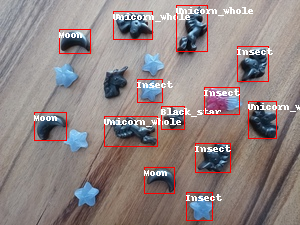

In [35]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image